In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from itertools import combinations
# paths
datos_g10_path = "https://raw.githubusercontent.com/apolineo11/PYEF/main/Cuadernos/Data/Datos_Probabilidad_Grupo_10.xlsx"
datos_g11_path = "https://raw.githubusercontent.com/apolineo11/PYEF/main/Cuadernos/Data/Datos_Probabilidad_Grupo_11.xlsx"

In [2]:
# leer los datos
datos_g10 = pd.read_excel(datos_g10_path)
datos_g11 = pd.read_excel(datos_g11_path, skiprows=1)

In [3]:
# limpieza datos
datos_g10.rename(columns={"ESTRATO DEL PREDIO DONDE VIVE":"ESTRATO",
                          "EDAD (AÑOS)":"EDAD",
                          "PROGRAMA ACADÉMICO":"PROGRAMA",
                          "NÚMERO DE MATRICULAS": "MATRICULAS",
                          "ESTATURA (CM)": "ESTATURA",
                          "PESO (KG)": "PESO"}, inplace=True)
datos_g11.rename(columns={"ESTRATO DEL PREDIO DONDE VIVE ":"ESTRATO",
                          "EDAD (AÑOS)":"EDAD",
                          "PROGRAMA ACADEMICO":"PROGRAMA",
                          "NUMERO DE MATRICULAS": "MATRICULAS",
                          "ESTATURA (CM)": "ESTATURA",
                          "PESO KG)": "PESO"}, inplace=True)
columns_df = ["ESTRATO", "EDAD", "PROGRAMA", "MATRICULAS", "ESTATURA", "PESO"]
datos_g10 = datos_g10[columns_df]
datos_g11 = datos_g11[columns_df]
df = pd.concat([datos_g10, datos_g11])
programa_dict = {"ADMINISTRACIÓN": "ADMINISTRACION", "ECONOMÍA":"ECONOMIA", "CONTADURÍA PÚBLICA":"CONTADURIA PUBLICA"}
df.replace({"PROGRAMA": programa_dict}, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.astype({"EDAD": "int32", "MATRICULAS":"int32", "ESTRATO":"int32", "PROGRAMA":"category"})
df["ESTRATO"] = df["ESTRATO"].astype("str").astype("category")
df["ESTRATO"] = df["ESTRATO"].cat.reorder_categories(["1", "2", "3", "4", "5", "6"], ordered=True)


In [4]:
df.head()

,ESTRATO,EDAD,PROGRAMA,MATRICULAS,ESTATURA,PESO
0,1,24,ADMINISTRACION,6,175.0,67.0
1,3,25,ADMINISTRACION,4,145.0,60.0
2,5,18,ECONOMIA,3,185.0,87.0
3,3,20,ECONOMIA,3,173.0,57.0
4,5,17,ADMINISTRACION,3,160.0,58.0


# Coeficiente de correlación de Tau

El coeficiente de correlación de $\tau$ mide la asociación de dos variables *"ordinales"*.
Dicha asociación compara el orden impuesto por una variable con el orden que impone la otra variable, la comparación se hace basado en el concepto de pares de datos **concordantes** y pares de datos **discordantes**.

Suponga que tiene un conjunto de datos de $n$ observaciones, en donde tiene a su vez medidas de las variables $X$ y $Y$, entonces:.

- El *k-esimo* individuo tiene un par de datos asociados: $(X_k = x_k, Y_k= y_k)$, donde $1 \leq k \leq n$.
- El valor que toma la variable $X$ para cada uno de los individuos le impone un orden al *k-esimo* individuo dentro del total de individuos. Lo mismo ocurre con la variable $Y$.
- Si tomo los $n$ pares de datos $(x_k, y_k)$ como los elementos de un conjunto de tamaño $n$. Entonces el total de formas en las que es posible armar subconjuntos de tamaño $2$ sin importar el orden. Es decir, la totalidad de emparejamientos posibles entre los $n$ individuos viene dada por la expresión:

 $$\binom{n}{2} = \frac{n!}{(n-2)!2!}$$

- Sea $\{(x_i,y_i), (x_j,y_j)\}$, uno de los posibles pares,  se dice que:
    - Es un par **concordante** si:
        - $(x_i > x_j \land y_i > y_j) \lor (x_i < x_j \land y_i < y_j)$
    - Es un par ****discordante** si:
        - $(x_i > x_j \land y_i < y_j) \lor (x_i < x_j \land y_i > y_j)$
    - **Empate** si:
        - $(x_i = x_j) \lor (y_i = y_j)$

In [5]:
# Ejemplo
# Tomamos las variables estatura y peso
individuos = list(df[['ESTATURA', 'PESO']].itertuples(index=False, name=None))
emparejamientos = list(combinations(individuos, 2))
df_emparejamientos = pd.DataFrame([
    {'ESTATURA_1': a[0], 'PESO_1': a[1], 'ESTATURA_2': b[0], 'PESO_2': b[1]} 
    for a, b in emparejamientos
])

print(f"El total de emparejamientos es '{df_emparejamientos.shape[0]}'")
df_emparejamientos.head(20)

El total de emparejamientos es '3081'


,ESTATURA_1,PESO_1,ESTATURA_2,PESO_2
0,175.0,67.0,145.0,60.0
1,175.0,67.0,185.0,87.0
2,175.0,67.0,173.0,57.0
3,175.0,67.0,160.0,58.0
4,175.0,67.0,180.0,60.0
5,175.0,67.0,182.0,80.0
6,175.0,67.0,160.0,85.0
7,175.0,67.0,170.0,68.0
8,175.0,67.0,150.0,40.0
9,175.0,67.0,172.0,64.0


## Cálculo de concordancia

Definamos lo siguiente:

$$A_{ij} := \operatorname{sign}\left[(X_i - X_j)(Y_i - Y_j)\right] \in \{-1, 0, 1\}$$

Con esto:

- Si el par $(i,j)$ es concordante entonces $A_{ij} = 1$
- Si el par $(i,j)$ es discordante entonces $A_{ij} = -1$
- Si hay empate en el par $(i,j)$ entonces $A_{ij} = 0$.

Si hacemos la suma $(S)$ de esta variable sobre el total de los posibles pares, lo que equivale a calcular la diferencia entre el número total de pares concordantes $N_c$ y el total de pares discordantes $N_d$.

$$S = N_c - N_d$$

Acá se debe aclarar que en la definición de $A_{ij}$, debe haber una resstricción donde $i < j$. Esto es así para evitar contar doble vez un emparejamiento.

In [6]:
# calculo de concordantes
df_emparejamientos['A_ij'] = df_emparejamientos[["ESTATURA_1", "PESO_1", "ESTATURA_2", "PESO_2"]].apply(lambda x: np.sign((x.iloc[0]-x.iloc[2])*(x.iloc[1]-x.iloc[3])), axis=1)
S = df_emparejamientos['A_ij'].sum()
print(f"La diferencia entre el total de pares concordantes y discordantes es de: '{S}'")

La diferencia entre el total de pares concordantes y discordantes es de: '1351.0'


# Tau

Una vez tenemos la suma $S$, se necesita comparar con algo de referencia para saber que nos dice. Entonces, se compara con el total de pares posibles y con ello encontramos una medida relativa.

$$
\begin{aligned}
    \tau &= \frac{N_c - N_d}{\binom{n}{2}}\\
    \tau &= \frac{S}{\binom{n}{2}}
\end{aligned}
$$

Sin embargo, cuando hay empates, existen pares que no se pueden clasificar, lo que puede provocar una sobreestimación o subestimación del grado de asociación si se utiliza $\tau$ sin corrección. Es por ello que se corrije haciendo la comparación con el promedio geométrico de los pares realmente clasificados para las dos variables. Quedando así:

Sea:
- $\binom{n}{2} = N_0$
- $T_x$: El total de pares con empate en la variable $X$.
- $T_y$: El total de pares con empate en la variable $Y$.

Entonces se define:
$$
\begin{aligned}
    \tau_b &= \frac{N_c - N_d}{\sqrt{(N_0 - T_x)(N_0 - T_y)}}\\
    \tau_b &= \frac{S}{\sqrt{(N_0 - T_x)(N_0 - T_y)}}
\end{aligned}
$$

En el ejercicio diario siempre se usa el $\tau_b$.

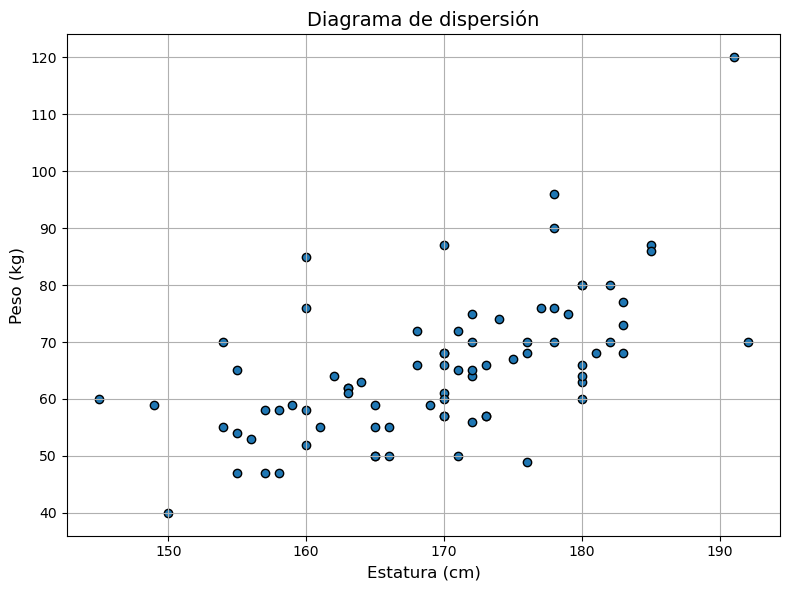

In [7]:
##############
# Dispersión #
##############

# scatter plot peso vs estatura
plt.figure(figsize=(8, 6))

# Crear scatter plot
plt.scatter(x=df["ESTATURA"], y=df["PESO"], edgecolors='k')

# Crear la linea de regresón
# Personalización
plt.title('Diagrama de dispersión', fontsize=14)
plt.xlabel('Estatura (cm)', fontsize=12)
plt.ylabel('Peso (kg)', fontsize=12)
plt.grid(True)

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [8]:
# Kendall Tau
tau, p_tau = kendalltau(df["ESTATURA"], df["PESO"])
print(f"El coeficiente de correlación Tau entre las variables 'PESO' y 'ESTATURA' es: '{tau:.3f}")

El coeficiente de correlación Tau entre las variables 'PESO' y 'ESTATURA' es: '0.452


## Prueba de hipótesis

El objetivo es evaluar si existe una asociación entre las variables $X$ y $Y$, ambas ordinales, el sistema de hipotesis se plantea así:


### Bilateral

- $H_0$: $\tau = 0$
- $H_1$: $\tau \neq 0$

### Unilateral

- $H_0$: $\tau = 0$
- $H_1$: $\tau > 0$ o $H_1$: $\tau < 0$

---

### Supuestos

- Recordemos que $S$ es una suma de variables aleatorias, y que si estás son independientes. el teorema central del límite garantiza que, bajo ciertas condiciones, la suma de muchas variables aleatorias débilesmente dependientes converge en distribución a una normal.
- Se asume que bajo la hipótesis nula, no existe asociación ente $X$ y $Y$. Por ende $E\left[S\right] = 0$
- Existe una varianza teorica dada la hipótesis nula. Existiendo una versión cuando no hay empates y otra cuando consideramos empates.

Con estos supuestos tenemos el estadístico:

$$Z = \frac{S}{\sqrt{Var(S)}} \sim N(0,1)$$

---

#### Varianza sin empates

Bajo la hipótesis nula y sin empates en los datos, la varianza del estadístico $S = N_c - N_d$ es:

$$
\operatorname{Var}(S) = \frac{n(n - 1)(2n + 5)}{18}
$$


---

### Varianza con empates

Cuando existen empates en las variables $X$ o $Y$, la varianza del estadístico $S = N_c - N_d$ se ajusta así:

$$
\operatorname{Var}(S) =
\frac{1}{18} \left[
n(n-1)(2n+5)
- \sum t_i(t_i - 1)(2t_i + 5)
- \sum u_j(u_j - 1)(2u_j + 5)
\right]
+ \frac{1}{9n(n-1)(n-2)} \left[
\sum t_i(t_i - 1)(t_i - 2)
\right]
+ \frac{1}{9n(n-1)(n-2)} \left[
\sum u_j(u_j - 1)(u_j - 2)
\right]
+ \frac{1}{2n(n-1)} \left[
\sum t_i(t_i - 1)
\right]
\left[
\sum u_j(u_j - 1)
\right]
$$

donde:

- $t_i$: número de observaciones con el mismo valor de $X$ (grupo de empates $i$).
- $u_j$: número de observaciones con el mismo valor de $Y$ (grupo de empates $j$).




In [9]:
print(f"El p-valor del estadístico S es de: '{p_tau:.3E}'")

El p-valor del estadístico S es de: '9.822E-09'
